# Dynamical systems
> Using `pydrake` to construct dynamical systems.

In [ ]:
import numpy as np
from pydrake.common.containers import namedview
from pydrake.systems.framework import BasicVector, LeafSystem
from pydrake.systems.analysis import Simulator

This tutorial provides a basic guide to construct a dynamical system with `pydrake`'s modeling capability.

__refs__:

- [dynamical_systems|official tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/dynamical_systems-28cb718798964f66a125eef7b3b29776)
- [LeafSystem|offical tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/authoring_leaf_systems-1638fb4a2fd9422f96b607171780e3c0)
- [diagram|official tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/working_with_diagrams-9efa8c3ef4244ac8bc69643ef2a75480)

## System

In `pydrake` and engineering, a _system_ is an abstraction consisting:

- input/ouput ports
- state
- parameters

```{mermaid}
graph LR
I["input1\ninput2\n..."]
O["output1\noutput2\n..."]

S["state;\nparameters"]
I-->S
S-->O
```

`pydrake` provides [a rich set of systems](https://drake.mit.edu/pydrake/pydrake.systems.primitives.html). We can also define our own dynamical systems deriving from the `LeafSystem` class.

::: {.callout-note appearance='simple'}
`pydrake` supports both numeric and _symbolic_ variables, however, we will omit the symbolic case in this tutorial.
:::

### I/O ports

In [ ]:
# I/O ports
class TstSys(LeafSystem):
    def __init__(self):
        super().__init__()
        self._inp = self.DeclareVectorInputPort(name='in', size=2)
        self.DeclareVectorOutputPort(name='out', size=2, calc=self.calc_outp)
    
    def calc_outp(self, ctx, outp):
        # Callback of the output port.
        # print(type(outp))
        res = self._inp.Eval(ctx)  # Use .Eval() to get the values
        outp.SetFromVector(res)    # Set the values of the output vector or use `.set_value()`

In [ ]:
tst_sys = TstSys()
ctx = tst_sys.CreateDefaultContext()
tst_sys.GetInputPort('in').FixValue(ctx, [0.,1])  # Fix the values of the input to constants
print(f"Evaluate/Call the input port: {tst_sys.GetInputPort('in').Eval(ctx)}")
print(f"Evaluate/Call the input port: {tst_sys.EvalVectorInput(ctx,0)}")  # convenient alternative _only_ for vector input
print(f"Evaluate/Call the output port: {tst_sys.GetOutputPort('out').Eval(ctx)}")

Evaluate/Call the input port: [0. 1.]
Evaluate/Call the input port: [0.0, 1.0]
Evaluate/Call the output port: [0. 1.]


In [ ]:
# We can get the I/O ports either by `attrs` or `.GetIn/OutputPort(name)`.
tst_sys.GetInputPort('in'), tst_sys._inp

(<pydrake.systems.framework.InputPort>,
 <pydrake.systems.framework.InputPort>)

::: {.callout-note appearance='simple' title="Context"}
You may have notice the keyword `ctx` which is a shorthand for `Context`. In `pydrake`, each `System` has it own `Context`, which basically _stores_ all information we needs to actually run it (_think of it as a 'table', a system knows how to make its own table, `.CreateDefaultContext()`, for users or other codes to edit_). A `Context` includes the time `t`, the state `x`, any inputs `u`, and any system parameters `p`. Note, __all__ inputs of a `System` must be defined, either tied to the outputs of another system or fixed via `FixValue()`.
:::

### State

In [ ]:
# State
class TstSys(LeafSystem):
    def __init__(self):
        super().__init__()
        self._ds1 = self.DeclareDiscreteState(1)  # DiscreteStateIndex(0), aka group number
        self._ds2 = self.DeclareDiscreteState(2)  # DiscreteStateIndex(1)
        self._cs = self.DeclareContinuousState(2) # ContinuousStateIndex(0), can _only_ have zero or one continous state, i.e. 0
        self._ds1_outp = self.DeclareStateOutputPort('ds1', self._ds1)
        self._cs_outp = self.DeclareStateOutputPort('cs', self._cs)

        # Set the rules on how to update the discrete states, i.e. `x[n+1] = f(n,x[n],u,p)`.
        # Starting from `offset_sec` and every `period_sec`.
        # Different dicrete states can be updated with their own rules.
        self.DeclarePeriodicDiscreteUpdateEvent(period_sec=1.0, offset_sec=0.0, update=self.update1)
        self.DeclarePeriodicDiscreteUpdateEvent(period_sec=2.0, offset_sec=0.0, update=self.update2)

    def update1(self, ctx, outp):
        print(f'update1 is called at {ctx.get_time()}s')
        # print(type(outp))
        x = ctx.get_discrete_state(0).get_mutable_value()  # _ds1
        xp = x**2
        outp.get_mutable_vector(0).set_value(xp)

    def update2(self, ctx, outp):
        print(f'update2 is called at {ctx.get_time()}s')
        # print(type(outp))
        x = ctx.get_discrete_state(1).get_mutable_value()  # _ds2
        xp = x+1
        outp.get_mutable_vector(1).set_value(xp)
    
    # For continous state.
    # xdot = f(x,u,t,p)
    def DoCalcTimeDerivatives(self, ctx, outp):
        # print(type(outp))
        x = ctx.get_continuous_state_vector().get_mutable_value()
        xd = -x
        outp.get_mutable_vector().SetFromVector(xd)  # Or with `.set_value()`

In [ ]:
tst_sys = TstSys()
sim = Simulator(tst_sys)
ctx = sim.get_mutable_context()

# Set initial states
ctx.SetDiscreteState(0, [.9])  # idx (group num), vals
ctx.SetDiscreteState(1, [1., 2.])
ctx.SetContinuousState([2., -2.])
print('===Inital===')
print(f'discrete1: {ctx.get_discrete_state(0)}, discrete2: {ctx.get_discrete_state(1)};\ncontinous: {ctx.get_continuous_state_vector()}\n')

# Simulate
sim.AdvanceTo(4.)
print('===Current===')
print(f'discrete1: {ctx.get_discrete_state(0)}, discrete2: {ctx.get_discrete_state(1)};\ncontinous: {ctx.get_continuous_state_vector()}\n')

===Inital===
discrete1: [0.9], discrete2: [1.0, 2.0];
continous: [2.0, -2.0]

update1 is called at 0.0s
update2 is called at 0.0s
update1 is called at 1.0s
update1 is called at 2.0s
update2 is called at 2.0s
update1 is called at 3.0s
===Current===
discrete1: [0.18530201888518424], discrete2: [3.0, 4.0];
continous: [0.036626510817661724, -0.036626510817661724]



::: {.callout-tip appearance='simple'}
`.get_discrete_state_vector()` is a convenience method that can _only_ be called when there is no more than _one_ group of discrete state. Otherwise, `.get_discrete_state(0).get_mutable_value()` does the same thing and works in general.
:::

In [ ]:
tst_sys.EvalTimeDerivatives(ctx)
# tst_sys.EvalUniquePeriodicDiscreteUpdate(ctx).get_vector()  # works if there is _only one_ discrete update event

<pydrake.systems.framework.ContinuousState>

::: {.callout-note appearance='simple' title=Vector}
Vectors in `pydrake` are special datatypes, e.g. [`VectorBase`](https://drake.mit.edu/pydrake/pydrake.systems.framework.html?highlight=basicvector#pydrake.systems.framework.VectorBase) and [`BasicVector`](https://drake.mit.edu/pydrake/pydrake.systems.framework.html?highlight=basicvector#pydrake.systems.framework.BasicVector). `VectorBase` is an abstract base class, it has methods like `.GetAtIndex()`, `.SetAtIndex()`, `.SetFromVector()`, and `.CopyToVector()`; `BasicVector` inherits all those and has additional methods like `.get_value()` and `.set_value()`.

`.get_mutable_vector()` returns an _editable_ vector object, while `.get_vector()` is _only_ for read; same goes for `.get_mutable_value()` and `.get_value()`.
:::

::: {.callout-note appearance='simple' title=`outp`}
I have used `outp` as a semantic-free word in all examples, and its `type(outp)` should be clear from the context where it appears. E.g., in `calc_outp(ctx, outp)`, `outp` is just a container, i.e. `BasicVector`; in `update(ctx, outp)`, it is `DiscreteValues`; in `DoCalcTimeDerivatives(ctx, outp)` it is `ContinuousState`.
:::

### Parameters, publish and namedview

In [ ]:
# Parameters
class TstSys(LeafSystem):
    param_names = namedview('params', ('temp','vol'))  # Belongs to the class
    def __init__(self):
        super().__init__()
        self.DeclareNumericParameter(BasicVector([23, 1]))  # Must be `BasicVector`
        # Calling `ForcedPublish()` on `System` will trigger this callback.
        self.DeclareForcedPublishEvent(self.publish)
        # Publish once every second.
        self.DeclarePeriodicPublishEvent(period_sec=1, offset_sec=0, publish=self.publish)
        
    def publish(self, ctx):
        params = self.param_names(ctx.get_numeric_parameter(0).get_value())
        print(f"publish parameters: temp={params.temp}, vol={params.vol}")

In [ ]:
tst_sys = TstSys()
sim = Simulator(tst_sys)
ctx = tst_sys.CreateDefaultContext()

sim.AdvanceTo(2)
print('\n===ForcedPublish===')
tst_sys.ForcedPublish(sim.get_context())

publish parameters: temp=23.0, vol=1.0
publish parameters: temp=23.0, vol=1.0
publish parameters: temp=23.0, vol=1.0

===ForcedPublish===
publish parameters: temp=23.0, vol=1.0


::: {.callout-tip appearance='simple'}
`namedview` is similar to `namedtuple` in `python`, it enables us to access the values of an array by their `field names`. Note that an instantiated object is a _view (reference)_ of the source not a _copy_.
:::

## Simulator

In [ ]:
from pydrake.systems.analysis import GetIntegrationSchemes, ExtractSimulatorConfig, ApplySimulatorConfig, PrintSimulatorStatistics

A `Simulator` can advance the state of a `System`to desired `boundary_time` (sec). The default integrator uses RK3, we can check available schemes from `GetIntegrationSchemes()`.


Each `Simulator` has its _internally-maintained_ `Context`, i.e. independent of that of a `System` or any current `ctx` in use. We can `.reset_context(ctx)` to replace the internal one with `ctx`. 

In [ ]:
GetIntegrationSchemes()

['bogacki_shampine3',
 'explicit_euler',
 'implicit_euler',
 'radau1',
 'radau3',
 'runge_kutta2',
 'runge_kutta3',
 'runge_kutta5',
 'semi_explicit_euler',
 'velocity_implicit_euler']

In [ ]:
# Configure a simulator
tst_sys = TstSys()
sim = Simulator(tst_sys)

sim_cfg = ExtractSimulatorConfig(sim)
print(f'===Before cfg===\n{sim_cfg}\n')

sim_cfg.integration_scheme = 'explicit_euler'
ApplySimulatorConfig(sim_cfg, sim)
print(f'===After cfg===\n{sim_cfg}')

===Before cfg===
SimulatorConfig(integration_scheme='runge_kutta3', max_step_size=0.1, accuracy=0.0001, use_error_control=True, target_realtime_rate=0.0, publish_every_time_step=False)

===After cfg===
SimulatorConfig(integration_scheme='explicit_euler', max_step_size=0.1, accuracy=0.0001, use_error_control=True, target_realtime_rate=0.0, publish_every_time_step=False)


In [ ]:
# Print simulation details
sim.AdvanceTo(2)
PrintSimulatorStatistics(sim)

publish parameters: temp=23.0, vol=1.0
publish parameters: temp=23.0, vol=1.0
publish parameters: temp=23.0, vol=1.0
General stats regarding discrete updates:
Number of time steps taken (simulator stats) = 2
Simulator publishes every time step: false
Number of publishes = 3
Number of discrete updates = 0
Number of "unrestricted" updates = 0

Note: the following integrator took zero steps. The simulator exclusively used the discrete solver.

Stats for integrator ExplicitEulerIntegrator with fixed steps:
Number of time steps taken (integrator stats) = 0
Number of derivative evaluations = 0
Number of steps shrunk due to convergence-based failure = 0
Number of convergence-based step failures (should match) = 0


### Monitor

Use monitors to [print, record, and interrupt](https://drake.mit.edu/pydrake/pydrake.systems.analysis.html?highlight=simulator#pydrake.systems.analysis.Simulator.set_monitor) simulations. For logging, we can use `pydrake`'s `LogVectorOutput` and `VectorLogSink` in a `Diagram`.

In [ ]:
from pydrake.systems.framework import EventStatus

In [ ]:
_stats = []
def recorder(ctx):
    print((_t:=ctx.get_time()))
    _stats.append(_t)
    return EventStatus.Succeeded()
def early_stop(ctx):
    if ctx.get_time() > .5: return EventStatus.ReachedTermination(tst_sys, 't=.5 reached')
    return EventStatus.Succeeded()

In [ ]:
tst_sys = TstSys()
sim = Simulator(tst_sys)

# Can have only one monitor
sim.set_monitor(recorder)
# sim.set_monitor(early_stop)

In [ ]:
status = sim.AdvanceTo(.5)
status.message(), _stats

publish parameters: temp=23.0, vol=1.0
0.0
0.5


('', [0.0, 0.5])

## Diagram

A `Diagram` is a collection of `System`s inter-connected together. It is also a `System`, i.e. we can form _nested_ diagrams.

In [ ]:
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import AffineSystem, ConstantVectorSource ,LogVectorOutput

In [ ]:
inp_src = ConstantVectorSource(np.array([1.,2.]))
aff_sys = AffineSystem(A=-np.eye(2), B=-np.eye(2), C=np.eye(2), y0=np.ones(2))
builder = DiagramBuilder()
# Add subsystems
builder.AddNamedSystem('src', inp_src)
builder.AddNamedSystem('aff', aff_sys)
# Connect subsystems
builder.Connect(inp_src.get_output_port(), aff_sys.get_input_port())
# Export I/O port of a diagram, no inputport in this example
builder.ExportOutput(aff_sys.get_output_port())
# Add logger
logger = LogVectorOutput(aff_sys.get_output_port(), builder, 0.1)  # publish_period=0.1
logger.set_name('aff_outp')

dgm = builder.Build()
dgm.set_name('aff_diag')

In [ ]:
import pydot
from IPython.display import SVG, display
import matplotlib.pyplot as plt

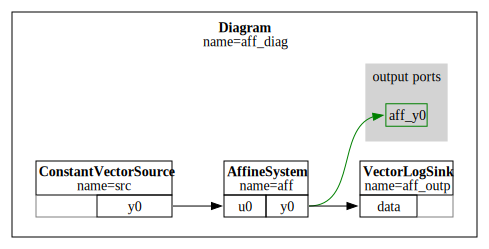

In [ ]:
#| eval: false
display(SVG(pydot.graph_from_dot_data(dgm.GetGraphvizString(max_depth=2))[0].create_svg()))

In [ ]:
sim = Simulator(dgm)
ctx = sim.get_mutable_context()

logger.FindMutableLog(ctx).Clear()
sim.AdvanceTo(2)
log = logger.FindLog(ctx)

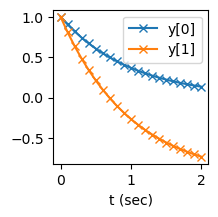

In [ ]:
ts,vals = log.sample_times(),log.data()
fig,ax = plt.subplots(figsize=(2,2))
ax.plot(ts, vals[0], 'x-', label='y[0]')
ax.plot(ts, vals[1], 'x-', label='y[1]')
ax.set_xlabel('t (sec)')
ax.legend();

### Context from root

The `Context` of a `Diagram` is a nested (tree) of its subsystems' `Context`s. It is preferable to change the values of a subsystem's `Context` by retrieving it from the _root_.

In [ ]:
dgm_ctx = dgm.CreateDefaultContext()
print(dgm_ctx)

::aff_diag Context (of a Diagram)
----------------------------------
2 total continuous states
2 total numeric parameters in 1 groups

::aff_diag::src Context
------------------------
Time: 0
Parameters:
  1 numeric parameter groups with
     2 parameters
       1 2

::aff_diag::aff Context
------------------------
Time: 0
States:
  2 continuous states
    0 0




In [ ]:
# Context from root
src_ctx = inp_src.GetMyContextFromRoot(dgm_ctx)
src_ctx.get_numeric_parameter(0).set_value([-1,-2.])
print(dgm_ctx)

::aff_diag Context (of a Diagram)
----------------------------------
2 total continuous states
2 total numeric parameters in 1 groups

::aff_diag::src Context
------------------------
Time: 0
Parameters:
  1 numeric parameter groups with
     2 parameters
       -1 -2

::aff_diag::aff Context
------------------------
Time: 0
States:
  2 continuous states
    0 0


